In [1]:
# ライブラリのインストールが必要な場合
# !pip install opencv-python-headless
# !pip install matplotlib
# !pip install numpy
# !pip install pillow

In [1]:
import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [2]:
def camera_to_image(P_camera, intrinsic_matrix):
    P_image_homogeneous = np.dot(intrinsic_matrix, P_camera)
    P_image = P_image_homogeneous[:2] / P_image_homogeneous[2]
    return P_image

In [3]:
# 変更しないでください
intrinsic_matrix = np.array([[226.16438356, 0., 63.62426614],
                             [0., 224.82352941, 11.76],
                             [0., 0., 1.]])

In [ ]:
import polars as pl
from PIL import Image

df = pl.read_csv(constants.DATA_DIR / "train_features.csv")
sample_id = "7a36f9391f1e82a094e76118a99a08fa_120"
images_dir = ... # path/to/images dir
target_cols = ... # x_0, y_0, z_0, ...
image = Image.open(images_dir / sample_id / "image_t.png")
trajectory = (
    df.filter(pl.col("ID") == sample_id)[target_cols]
    .transpose(include_header=True)
    .rename({"column": "coordinate", "column_0": "value"})
    .with_columns(
        axis=pl.col("coordinate").str.extract(r"([xyz])"),
        number=pl.col("coordinate").str.extract(r"(\d+)$").cast(pl.Int32),
    )
    .pivot(index="number", on="axis", values="value")
    .sort("number")
    .to_numpy()[:, 1:]
)
print(trajectory)

In [5]:
# 適宜変えてください
sample_id = "7a36f9391f1e82a094e76118a99a08fa_120"

images_dir = Path("../dataset/images/")
image = Image.open(images_dir / sample_id / "image_t.png")

trajectory_dir = Path("../dataset/train/target")
trajectory = np.load(trajectory_dir / f"{sample_id}.npy")

In [6]:
def project_trajectory_to_image_coordinate_system(trajectory: np.ndarray, intrinsic_matrix: np.ndarray):
    """車両中心座標系で表現されたtrajectoryをカメラ座標系に投影する"""
    # カメラの設置されている高さ(1.22m)まで座標系をズラす
    trajectory_with_offset = trajectory.copy()
    trajectory_with_offset[:, 2] = trajectory_with_offset[:, 2] + 1.22

    # 座標の取り方を変更する
    road_to_camera = np.array([[0, 0, 1], [-1, 0, 0], [0, 1, 0]])
    trajectory_camera = trajectory_with_offset @ road_to_camera
    trajectory_image = np.array([camera_to_image(p, intrinsic_matrix) for p in trajectory_camera if p[2] > 0])
    return trajectory_image


def overlay_trajectory(trajectory: np.ndarray, image: Image.Image, intrinsic_matrix: np.ndarray, figsize=(5.12, 2.56)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.set_axis_off()
    ax.imshow(image)

    trajectory_image = project_trajectory_to_image_coordinate_system(trajectory, intrinsic_matrix)
    ax.plot(
        trajectory_image[:, 0],
        trajectory_image[:, 1],
        marker="o",
        color="forestgreen",
        alpha=1.0,
        markersize=3,
        linestyle="solid",
    )
    ax.set_xlim(0, 128)
    ax.set_ylim(64, 0)
    plt.show()

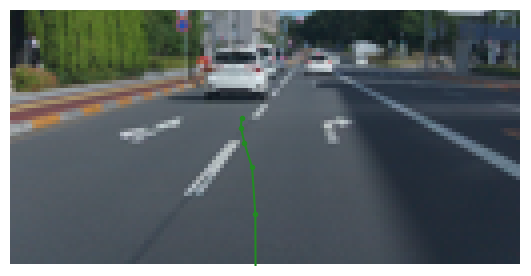

In [7]:
overlay_trajectory(trajectory, image, intrinsic_matrix)